In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [2]:
node_id = '10004098'
dir_out = '../figures/spatial/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

# Read Data

In [3]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '_NEXRAD_5km_landsat.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')

# iwant = df.index.date < datetime.date(2020, 3, 1)
# df = df[iwant]

surface_reflectances_rename =  {'Surface Reflectance Band 1' : 'Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                                'Surface Reflectance Band 2' : 'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                                'Surface Reflectance Band 3' : 'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                                'Surface Reflectance Band 4' : 'Surface Reflectance 636-673 nm'} # 636-673nm, Readm

surface_reflectances = ['Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                        'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                        'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                        'Surface Reflectance 636-673 nm'] # 636-673nm, Red

df = df.rename(columns=surface_reflectances_rename)
df.head()

,Illuminance,360nm,361nm,362nm,363nm,364nm,365nm,366nm,367nm,368nm,...,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,LocalTime,date,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-08 16:43:50,2345.220551,0.032529,0.032651,0.033183,0.033997,0.034946,0.035627,0.036239,0.036761,0.037158,...,NaN,NaN,NaN,NaN,2020-01-08 10:43:50,2020/01/08,582,656,925,1029
2020-01-08 16:44:00,2385.540894,0.033112,0.033226,0.033758,0.034580,0.035541,0.036231,0.036851,0.037380,0.037782,...,NaN,NaN,NaN,NaN,2020-01-08 10:44:00,2020/01/08,974,1096,1371,1635
2020-01-08 16:46:40,3521.045288,0.036604,0.036802,0.037441,0.038386,0.039475,0.040252,0.040949,0.041550,0.042018,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:40,2020/01/08,907,1043,1421,1676
2020-01-08 16:46:50,4220.051209,0.044110,0.044308,0.045068,0.046215,0.047553,0.048541,0.049440,0.050220,0.050827,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:50,2020/01/08,1042,1167,1566,1761
2020-01-08 16:47:00,4105.486389,0.043972,0.044196,0.044981,0.046150,0.047503,0.048477,0.049356,0.050115,0.050708,...,NaN,NaN,NaN,NaN,2020-01-08 10:47:00,2020/01/08,841,925,1185,1359


In [4]:
# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# neighbor parameters
neighbor = {'': (0, 0)}
km_max = 5
for i in range(1,km_max+1): # distance (km)
    neighbor['North_%dkm'          %(i  )] = ( i*delta_iy,           0)
    neighbor['North_%dkm East_%dkm'%(i,i)] = ( i*delta_iy,  i*delta_ix)
    neighbor[           'East_%dkm'%(  i)] = (          0,  i*delta_ix)
    neighbor['South_%dkm East_%dkm'%(i,i)] = (-i*delta_iy,  i*delta_ix)
    neighbor['South_%dkm'          %(i  )] = (-i*delta_iy,           0)
    neighbor['South_%dkm West_%dkm'%(i,i)] = (-i*delta_iy, -i*delta_ix)
    neighbor[           'West_%dkm'%(  i)] = (          0, -i*delta_ix)
    neighbor['North_%dkm West_%dkm'%(i,i)] = ( i*delta_iy, -i*delta_ix)
    

In [5]:
features0 = ['altitude', 'Zenith', 'Azimuth', 'Sun Distance']
# features0 = ['Zenith', 'Sun Distance']

features = features0.copy()
reflectivities = []
for iz in range(num_z):
    for direction in neighbor:
        var = 'Reflectivity Level_%dkm' % (iz)
        if direction:
            var += ' ' + direction
        reflectivities.append(var)

features += reflectivities

features += surface_reflectances
features = np.array(features)

num_features = len(features)
print(num_features)

wavelengths = np.array(range(360,780+1))#.astype(str)
targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
# targets = ['Illuminance']


459


In [6]:
# try to apply exp on the reflectivities
# since L_Z=10 log10(Z/Z_0) in dbz
# so (Z/Z_0) = 10^(L_z/10)
df[reflectivities] = (10**(df[reflectivities]/10)).fillna(0)

In [8]:
# cut off the brightness of night or when the sensor is covered
iwant = (df['Illuminance'] > 1000) #& (df.index.date < datetime.date(2020, 4, 1))

In [9]:
X = df[features][iwant]
Y = df[targets][iwant] # model and scaler use multi output

In [403]:
# def showCorr(cols):
#     size = len(cols)*0.8
#     fig = plt.figure(figsize=(size, size))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(df[cols].corr(), cmap='RdBu')
#     cax.set_clim(-1, 1);
#     #plt.title('Correlation Matrix\n\n\n')
#     fig.colorbar(cax)
#     ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
#     ax.set_yticklabels(np.append([""],cols))
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     plt.show()

In [507]:
# showCorr(np.append(features, targets[0]))

In [11]:
X_train_all, X_test, Y_train_all, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=0)

In [31]:
# scale the output
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_valid_scaled = scaler_y.transform(Y_valid)
Y_test_scaled = scaler_y.transform(Y_test)


In [34]:
num_features

459

In [126]:
# PCA to the scaled output

n_components = 3

DR = 'PCA'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

Y_train_scaled_DR = pca.fit_transform(Y_train_scaled)
Y_valid_scaled_DR = pca.transform(Y_valid_scaled)
Y_test_scaled_DR = pca.transform(Y_test_scaled)

Y_train_scaled_DR = pd.DataFrame(Y_train_scaled_DR, index = Y_train.index)
Y_valid_scaled_DR = pd.DataFrame(Y_valid_scaled_DR, index = Y_valid.index)
Y_test_scaled_DR = pd.DataFrame(Y_test_scaled_DR, index = Y_test.index)

print(pca.explained_variance_)

[4.13678829e+02 7.00593283e+00 1.99329190e-01]


# Model Trainning

In [48]:
import lightgbm as lgb
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
DR = ''

In [ ]:
# RandomizedSearchCV
rs_params = {
#     'boosting_type': ['gbdt'], # default = 'gbdt'
    'num_leaves': range(2, 160), # default = 31, Maximum tree leaves for base learners
    'max_depth' : [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], # default = -1, Maximum tree depth for base learners
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4], # default = 0.1
    'n_estimators': range(10, 200, 10), # default = 100, Number of boosted trees
#     'subsample_for_bin': [200000], # default = 200000
    'objective' : ['regression'], # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
#     'class_weight': ['balanced'], # default = None, for multi-class
#     'is_unbalance': [True], # default = False, for binary
#     'min_split_gain' : [0.], # default=0.
#     'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], # default=1e-3
#     'min_child_samples': range(1, 500), # default=20
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
#     'subsample_freq': [0], # default=0
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
    'reg_alpha': [0, 1e-1, 0.5, 1, 2, 5, 7, 10, 50, 100], # default=0.  L1 regularization
    'reg_lambda': [0, 1e-1, 0.5, 1, 5, 10, 20, 50, 100], # default=0.  L2 regularization
    'random_state' : [RANDOM_STATE], # default=None
#     'n_jobs': [-1], # default=-1
    'silent': [True], # default=True
#     'importance_type': ['split'], # default='split', or 'gain'
}

start_time = time.time()
# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state = RANDOM_STATE), 
                           param_distributions = rs_params,
#                            scoring= '',
                           refit = True,
                           verbose = True,
                           cv = 2,
                           n_jobs = -1,
                           n_iter = 1000,
                          )
fit_params = {"early_stopping_rounds":30, 
              "eval_metric" : 'mse', #
              "eval_set" : [(X_valid, Y_valid.values[:,0])],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto'
             }

# Train on training data
warnings.filterwarnings("ignore")
# rs_cv.fit(X_train_scaled_DR_scaled, Y_train_scaled, **fit_params)
rs_cv.fit(X_train, Y_train.values[:,0], **fit_params)

print(rs_cv.best_params_)
print(rs_cv.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

In [324]:
rs_cv.best_params_

{'subsample': 0.5,
 'silent': True,
 'reg_lambda': 50,
 'reg_alpha': 5,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 113,
 'n_estimators': 110,
 'max_depth': -1,
 'learning_rate': 0.2,
 'colsample_bytree': 0.5}

In [128]:
# Fit the Model with Optimized Hyper-Parameters
# param = {
#     'num_leaves': 128, # default = 31, Maximum tree leaves for base learners
#     'max_depth' : -1, # default = -1, Maximum tree depth for base learners
#     'learning_rate': 0.05, # default = 0.1
#     'n_estimators': 140, # default = 100, Number of boosted trees
# #     'subsample_for_bin': 200000, # default = 200000
#     'objective' : 'regression', # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
# #     'class_weight': 'balanced', # default = None, for multi-class
# #     'min_child_weight' : 100., # default=1e-3
# #     'min_child_samples': 467, # default=20
#     'subsample': 1.0, # default=1.
#     'colsample_bytree': 0.9, # default=1.
#     'reg_alpha': 50, # default=0.  L1 regularization
#     'reg_lambda': 0, # default=0.  L2 regularization
#     'random_state' : RANDOM_STATE, # default=None
#     'silent': True, # default=True
# }

param = {
'subsample': 0.5,
'silent': True,
'reg_lambda': 50,
'reg_alpha': 5,
'random_state': 42,
'objective': 'regression',
'num_leaves': 113,
'n_estimators': 110,
'max_depth': -1,
'learning_rate': 0.2,
'colsample_bytree': 0.5
}

# structure   = '_' + DR + str(n_components) \
structure   = '_' + 'ne' + str(param['n_estimators'])\
            + '_' + 'de' + str(param['max_depth'])\
            + '_' + 'nl' + str(param['num_leaves'])\
            + '_' + 'sr' + str(param['subsample'])\
            + '_' + 'fr' + str(param['colsample_bytree'])\
            + '_' + 'l1_' + str(param['reg_alpha'])\
            + '_' + 'l2_' + str(param['reg_lambda'])\


model_base = lgb.LGBMRegressor(**param)
model = MultiOutputRegressor(model_base)

fit_params = {"early_stopping_rounds":30, 
              "eval_metric": 'mse', # l2 is mean_squared_error
              "eval_set": [(X_valid, Y_valid_scaled_DR)],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto', # default='auto'
             }

warnings.filterwarnings("ignore")
# model.fit(X_train_scaled_DR_scaled, Y_train_scaled)#, **fit_params)
model.fit(X_train, Y_train_scaled_DR)#, **fit_params)

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.5,
                                             learning_rate=0.2,
                                             n_estimators=110, num_leaves=113,
                                             objective='regression',
                                             random_state=42, reg_alpha=5,
                                             reg_lambda=50, subsample=0.5))

In [201]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_test_pred)

0.0005357462365760197

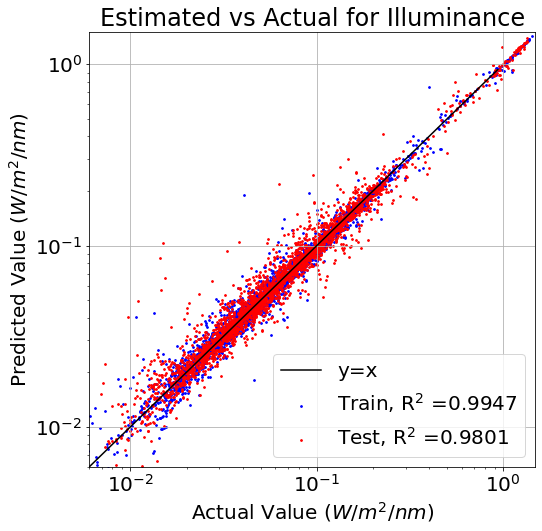

In [129]:
from sklearn.metrics import r2_score

# train
Y_train_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X_train)))#[reflectivities_DR] )
train_score = r2_score(Y_train, Y_train_pred)

# test
Y_test_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X_test)))#[reflectivities_DR] )
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 3000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 3000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(6E-3, )
plt.ylim(6E-3, )

ax.set_title('Estimated vs Actual for Illuminance')# Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
# plt.tight_layout()

if not os.path.exists(dir_out + 'Illuminance'):
    os.mkdir(dir_out + 'Illuminance')
# plt.savefig(dir_out + 'Illuminance' +'/Lightgbm_performance_whole'+structure+'.png')



In [130]:
Y_train_flatten_sorted = np.sort(Y_train_flatten)
Y_train_pred_flatten_sorted = np.sort(Y_train_pred_flatten)

Y_test_flatten_sorted = np.sort(Y_test_flatten)
Y_test_pred_flatten_sorted = np.sort(Y_test_pred_flatten)

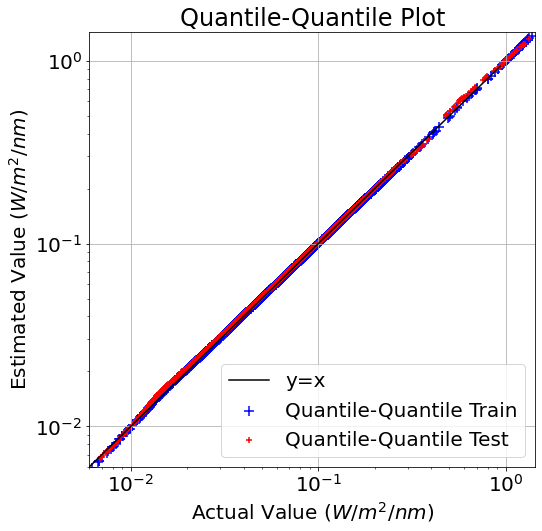

In [131]:
Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)
y_line = np.linspace(Y_min,Y_max,100)
# 

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten_sorted), 2000, replace = False)
plt.scatter(Y_train_flatten_sorted[id_train], Y_train_pred_flatten_sorted[id_train], s=100, c = 'blue',
            marker = '+', label = 'Quantile-Quantile Train')

id_test = np.random.choice(len(Y_test_flatten_sorted), 2000, replace = False)
plt.scatter(Y_test_flatten_sorted[id_test], Y_test_pred_flatten_sorted[id_test], s=30, c = 'red',
            marker = '+', label = 'Quantile-Quantile Test')
plt.xlim(6E-3, )
plt.ylim(6E-3, )

# x_25 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4]
# y_25 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4]
# x_50 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//2]
# y_50 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//2]
# x_75 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4*3]
# y_75 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4*3]
# plt.text(x_25, y_25, '25', c ='blue', ha = 'center', va = 'center')
# plt.text(x_50, y_50, '50', c ='blue', ha = 'center', va = 'center')
# plt.text(x_75, y_75, '75', c ='blue', ha = 'center', va = 'center')

ax.set_title('Quantile-Quantile Plot')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Estimated Value $(W/m^2/nm)$')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend( loc='lower right')

# plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
# plt.savefig(dir_out + 'whole' +'/Lightgbm_QQ_whole'+structure+'.png')


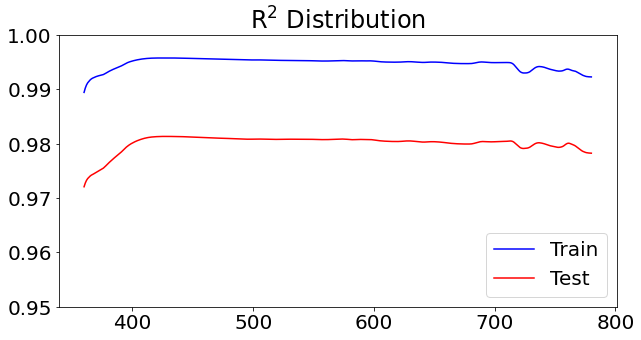

In [132]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )

plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.95,1)
plt.title("R$^2$ Distribution")
plt.legend( loc='lower right')
# plt.savefig(dir_out + 'whole' + '/Lightgbm_R2' + structure + '.png')


In [97]:
# Create object that can calculate shap values
num_shap = 500
start_time = time.time()
explainer0 = shap.TreeExplainer(model.estimators_[0])
tree_shap_values0 = explainer0.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components

explainer1 = shap.TreeExplainer(model.estimators_[1])
tree_shap_values1 = explainer1.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components

explainer2 = shap.TreeExplainer(model.estimators_[2])
tree_shap_values2 = explainer2.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components


print("--- %s seconds ---" % (time.time() - start_time))

--- 4.172516107559204 seconds ---


In [191]:
tree_shap_values_Xmulti_Yscaled = tree_shap_values0[:,:,None]*pca.components_[0][None,:] \
                                + tree_shap_values1[:,:,None]*pca.components_[1][None,:] \
                                + tree_shap_values2[:,:,None]*pca.components_[2][None,:]

# scaled SHAP values averaged on different wavelengths
tree_shap_values_Yscaled = np.mean(tree_shap_values_Xmulti_Yscaled, axis = -1)

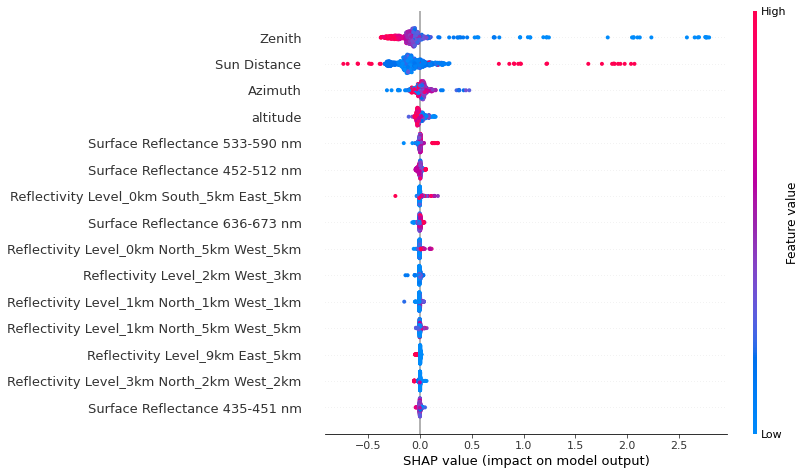

In [193]:
# plot
max_display = 15
# shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(tree_shap_values_Yscaled, X_train[:num_shap],
#                   feature_names = features_DR,
                  plot_size=(12,int(max_display/2)),#'auto'
                  max_display = max_display,
                  show=False
                 )
# plt.xlim(-20000, 30000)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/Lightgbm_shap_'+ 'whole' +structure+'.png')

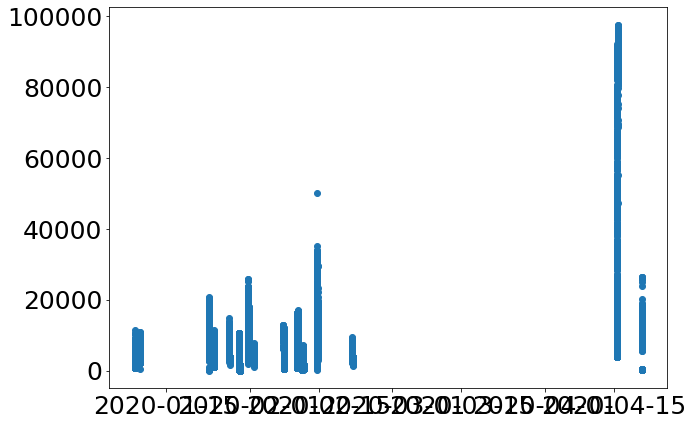

In [278]:
plt.scatter(df.index, df['Illuminance'])

In [202]:
# importances of sun direction/distance and altitude
print(features0)
importances[:4]

['altitude', 'Zenith', 'Azimuth', 'Sun Distance']


array([0.02617273, 0.21516235, 0.04602858, 0.18202994])

In [203]:
# sum of importances of NEXRAD reflectivities
importances[4:4+len(reflectivities)].sum()

0.30468584078027094

In [204]:
# sum of importances of landsat surface reflectance
importances[-len(surface_reflectances):].sum()

0.031780483168533394

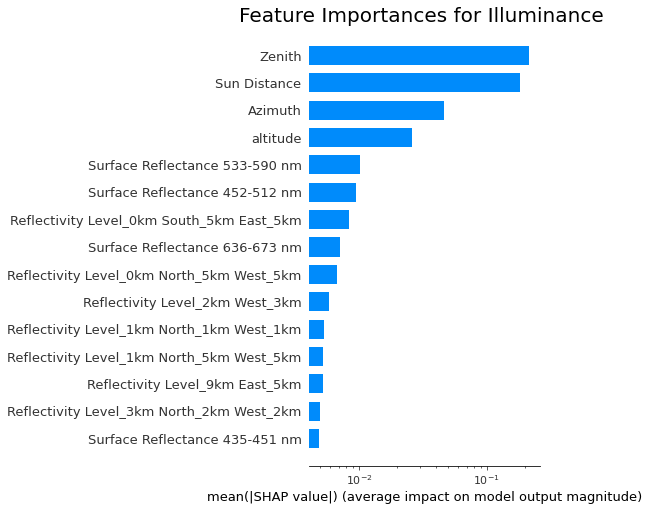

In [205]:
importances = np.mean(np.abs(tree_shap_values_Yscaled), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
# colormap = {1:'red',-1:'blue', 0:'grey'}
# impacts = np.array([])
# corrcoef = np.array([])
# sign = np.array([])
# for i in range(n_components):
#     impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
#     impacts = np.append(impacts, impact_i)

#     corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
#     corrcoef = np.append(corrcoef, corrcoef_i)
    
#     sign_i = np.sign(corrcoef_i)
#     sign = np.append(sign, sign_i)

# sign = sign[indices]
# impacts = impacts[indices]
# corrcoef = corrcoef[indices]

# # norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
# cmap = cm.get_cmap('RdBu_r')
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# color = [colormap[val] for val in sign]
# # color = [m.to_rgba(val) for val in impacts]
# # color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(tree_shap_values_Yscaled, X_train[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/2),#'auto'
#                   color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title('Feature Importances for Illuminance ', fontsize = 20)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/Lightgbm_'+'Importances_' + 'whole' + structure +'.png')


In [208]:
id_train = X_train.index
id_test = X_test.index

Zenith_train = df.loc[id_train, 'Zenith']
Zenith_test = df.loc[id_test, 'Zenith']

Azimuth_train = df.loc[id_train, 'Azimuth']
Azimuth_test = df.loc[id_test, 'Azimuth']


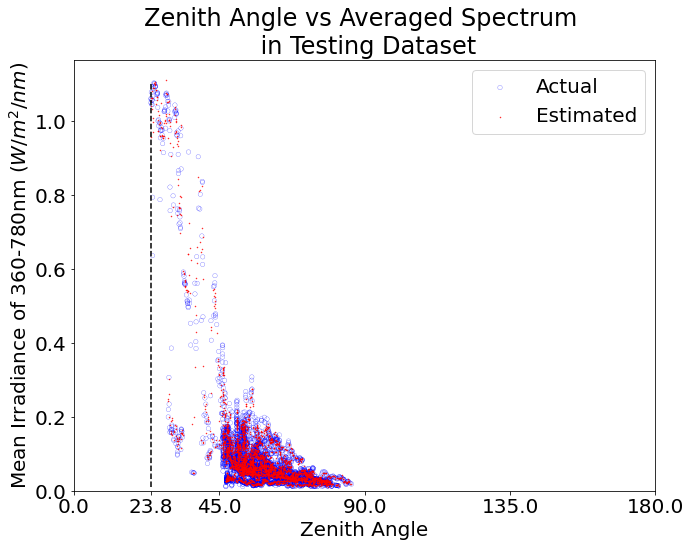

In [209]:
plt.rcParams["figure.figsize"] = (10, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
colors = 'black' #pca.transform(scaler_x.transform(X))[:,0]

y_min = Y_test.mean(axis = 1).min()
y_max = Y_test.mean(axis = 1).max()
Zenith_min = Zenith_test.min()

plt.scatter(Zenith_test, Y_test.mean(axis = 1), 
            marker = 'o', facecolors='none', edgecolors='blue', linewidths=0.2, s = 20,
            label = 'Actual')
plt.scatter(Zenith_test, Y_test_pred.mean(axis = 1), 
            marker = 'o', color = 'red', s = 0.2,
            label = 'Estimated')

plt.plot([Zenith_min, Zenith_min], [y_min, y_max], '--', c = 'black')

plt.xticks(list(np.linspace(0,180,5))+[Zenith_min]);
plt.xlabel('Zenith Angle');
plt.ylabel('Mean Irradiance of 360-780nm $(W/m^2/nm)$');
plt.title('Zenith Angle vs Averaged Spectrum \n in Testing Dataset')
plt.xlim(0,)
plt.ylim(0,)
plt.legend();
plt.tight_layout()
# plt.savefig(dir_out + 'whole' + '/Lightgbm_Zenith_vs_Averaged_' + 'whole' + structure +'.png')


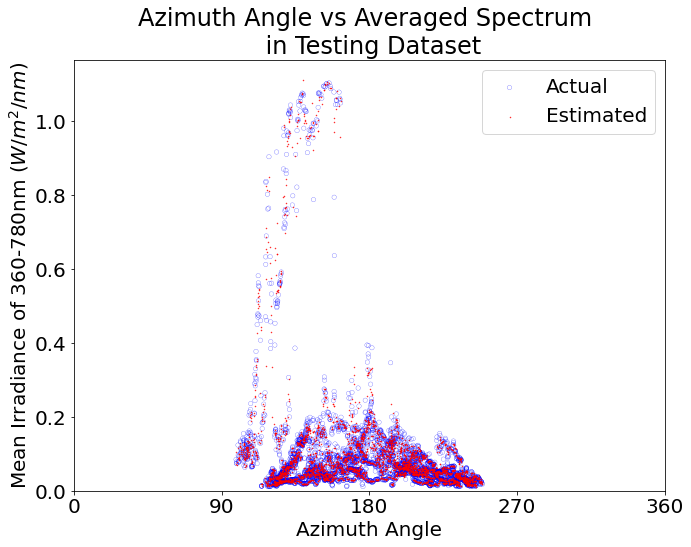

In [210]:
plt.rcParams["figure.figsize"] = (10, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
colors = 'black' #pca.transform(scaler_x.transform(X))[:,0]

y_min = Y_test.mean(axis = 1).min()
y_max = Y_test.mean(axis = 1).max()
# Azimuth_min = Azimuth_test.min()

plt.scatter(Azimuth_test, Y_test.mean(axis = 1),
            marker = 'o', facecolors='none', edgecolors='blue', linewidths=0.2, s = 20,
            label = 'Actual')
plt.scatter(Azimuth_test, Y_test_pred.mean(axis = 1),
            marker = 'o', color = 'red', s = 0.2,
            label = 'Estimated')

plt.xticks(list(np.linspace(0,360,5)));
plt.xlabel('Azimuth Angle');
plt.ylabel('Mean Irradiance of 360-780nm $(W/m^2/nm)$');
plt.title('Azimuth Angle vs Averaged Spectrum \n in Testing Dataset')
plt.xlim(0,)
plt.ylim(0,)
plt.legend();
plt.tight_layout()
# plt.savefig(dir_out + 'whole' + '/Lightgbm_Azimuth_vs_Averaged_' + 'whole' + structure +'.png')


## Compare Actual Spectrum and Estimated Spectrum


In [235]:
X_test[X_test.index.date == datetime.date(2020, 1, 31)][:5]

,altitude,Zenith,Azimuth,Sun Distance,Reflectivity Level_0km,Reflectivity Level_0km North_1km,Reflectivity Level_0km North_1km East_1km,Reflectivity Level_0km East_1km,Reflectivity Level_0km South_1km East_1km,Reflectivity Level_0km South_1km,...,Reflectivity Level_10km East_5km,Reflectivity Level_10km South_5km East_5km,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-31 15:11:00,215.840000,71.028897,126.981467,1.473745e+11,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,859,1003,1442,1634
2020-01-31 15:04:50,218.200000,72.050814,125.873803,1.473745e+11,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,655,768,958,1122
2020-01-31 19:34:00,210.083333,51.955433,196.313540,1.473762e+11,1.347548,0.0,1.320937,1.333632,1.345906,1.359934,...,0.0,0.0,0.0,0.0,0.0,0.0,591,687,892,976
2020-01-31 16:28:20,190.920000,59.433946,142.933276,1.473743e+11,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,742,894,1252,1459
2020-01-31 15:59:10,195.266667,63.434365,136.423857,1.473743e+11,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,959,1179,1589,1809


In [227]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

In [276]:
year1 = 2020
month1 = 2
day1 = 1
hour1 = 20
minute1 = 30
second1 = 30
lag = 6
date_string1 = '%04d-%02d-%02d %02d:%02d:%02d' % (year1, month1, day1, hour1, minute1, second1)
print(date_string1)

wavelengths = np.array(range(360,780+1))

iwant = (X_test.index== date_string1)
X1 = X_test[iwant]
Y1 = Y_test[iwant].values
Y1_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X1)))

2020-02-01 20:30:30


In [257]:
year2 = 2020
month2 = 2
day2 = 10
hour2 = 17
minute2 = 20
second2 = 50
lag = 6
date_string2 = '%04d-%02d-%02d %02d:%02d:%02d' % (year2, month2, day2, hour2, minute2, second2)
print(date_string2)

wavelengths = np.array(range(360,780+1))

iwant = (X_test.index== date_string2)
X2 = X_test[iwant]
Y2 = Y_test[iwant].values
Y2_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X2)))

2020-02-10 17:20:50


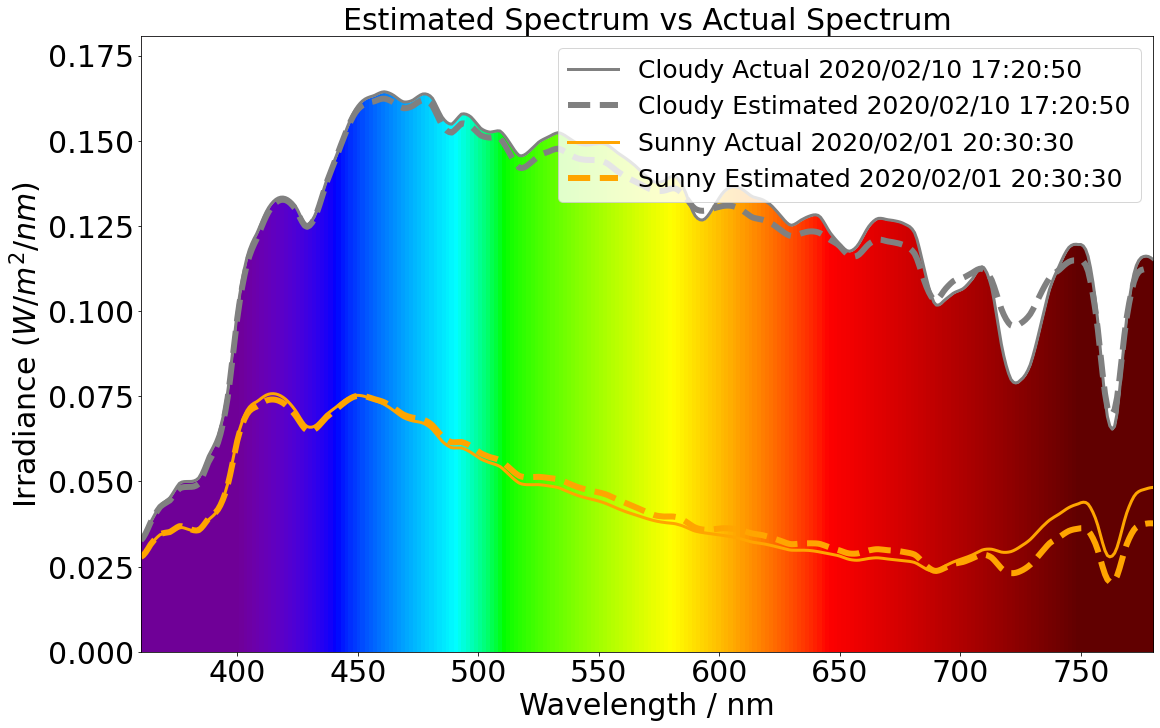

In [277]:
# compare
Y_max = max(Y1[0].max(), Y2[0].max())

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 10))
plt.rcParams.update({'font.size': 25})

## color
spectrum = Y2[0]
y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')



## compare
plt.plot(wavelengths, Y2[0], '-', color = 'gray', linewidth = 3, label = 'Cloudy Actual ' + date_string2.replace('-','/'))
plt.plot(wavelengths, Y2_pred[0], '--', color = 'gray', linewidth = 6, label = 'Cloudy Estimated ' + date_string2.replace('-','/'))

plt.plot(wavelengths, Y1[0], '-', color = 'orange', linewidth = 3, label = 'Sunny Actual ' + date_string1.replace('-','/'))
plt.plot(wavelengths, Y1_pred[0], '--', color = 'orange', linewidth = 6, label = 'Sunny Estimated ' + date_string1.replace('-','/'))

plt.xlim(360,780)
plt.ylim(0,Y_max*1.1)

ax.set_title('Estimated Spectrum vs Actual Spectrum')
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

plt.legend( loc='upper right')

# fig.savefig(dir_out+'Spectrum_'+ 
#             date_string1.replace('-','_').replace(' ','_').replace(':','_') + '_' + 
#             date_string2.replace('-','_').replace(' ','_').replace(':','_') +'.png' )
#plt.close()

In [272]:
# daily mean spectrum
date_start = datetime.datetime(2019,12,1)
years = [2019,2020]
months = [1,2,3,4,5,6,7,8,9,10,11,12]

hour_start_local = 6
hour_end_local = 19

hour_lag = 6
lag = datetime.timedelta(hours=hour_lag)

# plot daily spectrum
print("Plot Daily Spectrum")
for year in years:
    for month in months:
        for day in range(1,31+1):
            isValidDate = True
            try:
                datetime.datetime(year,month,day)
            except ValueError:
                isValidDate = False
                
            if not isValidDate:
                #print(df_iwant.head())
                continue
            if (datetime.datetime(year,month,day) < date_start):
                continue
            
            datetime_start = datetime.datetime(year, month, day, hour_start_local, 0, 0) + lag
            datetime_end   = datetime.datetime(year, month, day, hour_end_local,   0, 0) + lag
            iwant = (df.index > datetime_start) & (df.index < datetime_end)
            
            df_iwant = df[iwant].copy()
            if len(df_iwant)==0:
                continue
            print(year, month, day)
            
            x = (df_iwant.index)# UTC time #.hour.values[:]
            y = np.arange(360, 780+1, 1) # wave length
            xx, yy = np.meshgrid(x, y, sparse=True)
            z = np.transpose(df_iwant[targets].values)

            if np.shape(z)[1] == 0:
                continue
            
            plt.rcParams.update({'font.size': 30})
            fig, ax = plt.subplots(constrained_layout=True, figsize=(20, 10))
            h = ax.contourf(x,y,z,levels=20, cmap="RdBu_r")
            
            ax.set_title('Daily Spectrum: %02d/%02d/%02d' % (year,month,day), fontsize=40)
            ax.set_xlabel('Time / hour',fontsize=30)
            ax.set_ylabel('Wavelength / nm',fontsize=30)
            fig.colorbar(h, ax=ax)
            
            locator = mdates.HourLocator(interval = 1)
            h_fmt = mdates.DateFormatter('%H')
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(h_fmt)
            fig.autofmt_xdate()
            fig.savefig(dir_out+'Daily_Spectrum_%02d_%02d_%02d.png' % (year, month, day))
            plt.close()

Plot Daily Spectrum
2020 1 8
2020 1 9
2020 1 23
2020 1 24
2020 1 27
2020 1 29
2020 1 31
2020 2 1
2020 2 7
2020 2 10
2020 2 11
2020 2 14
2020 2 21
2020 4 15
2020 4 20
